In [1]:
import os.path
import cv2 as cv
import numpy as np
from random import randrange
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
class Project:
    
    @property
    def Images(self):
        return self.__images
    
    @Images.setter
    def Images(self, images):
        if not isinstance(images, list):
            raise TypeError("expected list of Images")
        
        for image in images:
            if not isinstance(image, Image):
                raise TypeError("expected list of Images")
        
        self.__images += images
            
    
    def __init__(self, project_root, project_name):
        self.project_root = project_root
        self.project_name = project_name
        
        self.__images = []
        
        self.InitProject()
        
    def InitProject(self):
        if not os.path.isdir(self.project_root):
            os.mkdir(self.project_root)
        
        # Prevent duplicate project names. 
        count = 1
        project_name = self.project_name
        project_path = os.path.join(self.project_root, self.project_name)        
        while os.path.isdir(project_path):
            project_name = self.project_name + str(count)
            project_path = os.path.join(self.project_root, project_name)
            count += 1
        
        self.project_name = project_name
        self.project_path = project_path
        
        os.mkdir(self.project_path)   
        
    def DetectKeypoints(self, minHessian = 400):
        surf = cv.xfeatures2d_SURF.create(hessianThreshold=minHessian)
        
        for image in self.__images:   
            print(f"calculating keypoints for {image.Path}")
            image.KeyPoints, image.Descriptors = surf.detectAndCompute(image.Gray, None) # detect features and compute descriptors.
            print(f"..found {len(image.KeyPoints)} for {image.Path}")
    
    def ComputeMatches(self, dMeasurment=cv.NORM_L2 ):
        # Create BFMatcher object.
        bf = cv.BFMatcher.create(dMeasurment , crossCheck=True)
        
        if len(self.__images) < 1:
            raise ValueError(f"at least two images are required to compute matches.")
        
        # We are searching for image matches against all other images. This
        # is very time consuming and not necessary. Implement options to
        # limit the number of match candidates. 
        for image in self.__images:            
            matches = []
            for match_to in self.__images:                
                # don't try to match the image against itself.
                if image == match_to:
                    continue
                    
                print(f"matching {image.Path} to {match_to.Path}")
                results = bf.match(image.Descriptors, match_to.Descriptors)
                # Sort them in the order of their distance.
                results = sorted(results, key = lambda x:x.distance)
                print(f"...found {len(results)}")
                
                match = Match(match_to, results)                
                matches.append(match)                
                
            image.MatchedImages = matches

class Image:
    
    @property
    def Path(self):
        return self.__image_path 
    
    @property
    def Original(self):
        return self.__image
    
    @property
    def Gray(self):
        return self.__gray_image
    
    @property
    def KeyPoints(self):
        return self.__keypoints
    
    @KeyPoints.setter
    def KeyPoints(self, keypoints):
        self.__keypoints = keypoints
        
    @property
    def Descriptors(self):
        return self.__descriptors
    
    @Descriptors.setter
    def Descriptors(self, descriptors):
        self.__descriptors = descriptors
    
    @property
    def MatchedImages(self):
        return self.__matches
    
    @MatchedImages.setter
    def MatchedImages(self, matches):
        if not isinstance(matches, list):
            raise TypeError("expected list of Matches")
            
        for match in matches:
            if not isinstance(match, Match):
                raise TypeError("expected list of Matches")
        
        self.__matches += matches
    
    def __init__(self, image_path):
        
        if os.path.isfile(image_path):
            self.__image_path = image_path
            self.__image = cv.imread(image_path) # original image as numpy array.
            self.__gray_image = cv.cvtColor(self.__image, cv.COLOR_BGR2GRAY) # grayscale image as numpy array.
        else:
            raise ValueError(f"{image_path} is not a valid image.")
            
        self.__keypoints = None 
        self.__descriptors = None
        self.__matches = []

        
class Match:
    
    @property
    def Matches(self):
        return self.__matches
    
    @property
    def MatchedTo(self):
        return self.__to_image
    
    def __init__(self, to_image, matches):
        self.__to_image = to_image
        self.__matches = matches
        
def FormatPlot(*argv):
    # Turn off axis lines and ticks of the subplot
    for arg in argv:
        arg.spines['top'].set_color('none')
        arg.spines['bottom'].set_color('none')
        arg.spines['left'].set_color('none')
        arg.spines['right'].set_color('none')
        arg.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

def DrawImagePairs(img0, img1):
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # Turn off axis lines and ticks of the subplots
    FormatPlot(ax1, ax2)

    ax1.imshow(img0)
    ax2.imshow(img1)

def DrawKeypointPairs(img1, img2, keypoints1, keypoints2):
    
    ptx = []
    pty = []
    for keypoint in keypoints1:
        x,y = keypoint.pt
        ptx.append(x)
        pty.append(y)
    
    ptx0 = []
    pty0 = []
    for keypoint in keypoints2:
        x,y = keypoint.pt
        ptx0.append(x)
        pty0.append(y)    

    # Plot the images with their keypoints.
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    FormatPlot(ax1, ax2)

    ax1.scatter(x=ptx, y=pty, color=(0,1,0), s=40, marker="x")
    ax2.scatter(x=ptx0, y=pty0, color=(0,1,0), s=40, marker="x")
    ax1.imshow(img1)
    ax2.imshow(img2)
    
def DrawMatches(img1, img2, keypoints1, keypoints2, img1_matches):
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    FormatPlot(ax1, ax2)

    for match in img1_matches:
        kp0 = keypoints1[match.queryIdx]
        kp1 = keypoints2[match.trainIdx]

        con = ConnectionPatch(xyA=kp1.pt, xyB=kp0.pt, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color=(0,1,0), linewidth=2.0)

        ax2.add_artist(con)

    ax1.imshow(img1)
    ax2.imshow(img2)
    
def DrawDescriptorPairs(img1, img2, k1, k2, ds1, ds2):
    fig = plt.figure(figsize=(30, 7))
    gs = fig.add_gridspec(2, 4)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])
    ax4 = fig.add_subplot(gs[:, 2])
    ax5 = fig.add_subplot(gs[0, 3])
    ax6 = fig.add_subplot(gs[1, 3])

    FormatPlot(ax2, ax3, ax4, ax6)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    ax1.hist(ds1, density=False, bins=36)
    ax2.imshow(img1)
    ax3.imshow(img1, aspect='auto')
    ax3.scatter(x=kp1.pt[0], y=kp1.pt[1], color=(0,1,0), s=200, marker="X")
    ax4.imshow(img2, aspect='auto')
    ax4.scatter(x=kp2.pt[0], y=kp2.pt[1], color=(0,1,0), s=200, marker="X")
    ax5.hist(ds2, density=False, bins=36)
    ax6.imshow(img2)

    # Draw connection path between matches.
    con = ConnectionPatch(xyA=kp2.pt, xyB=kp1.pt, coordsA="data", coordsB="data",
                              axesA=ax4, axesB=ax3, color=(0,1,0), linewidth=2.0)
    ax4.add_artist(con)

In [4]:
# Create project
my_project = Project(r"C:\Users\mar10675\Documents\FeatureMatching", "my_project")

# Add images to project.
image0 = Image(r"C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg")
image1 = Image(r"C:\Users\mar10675\JupyterOnGitHub\Images\cat_train.jpg")

my_project.Images = [image0, image1]

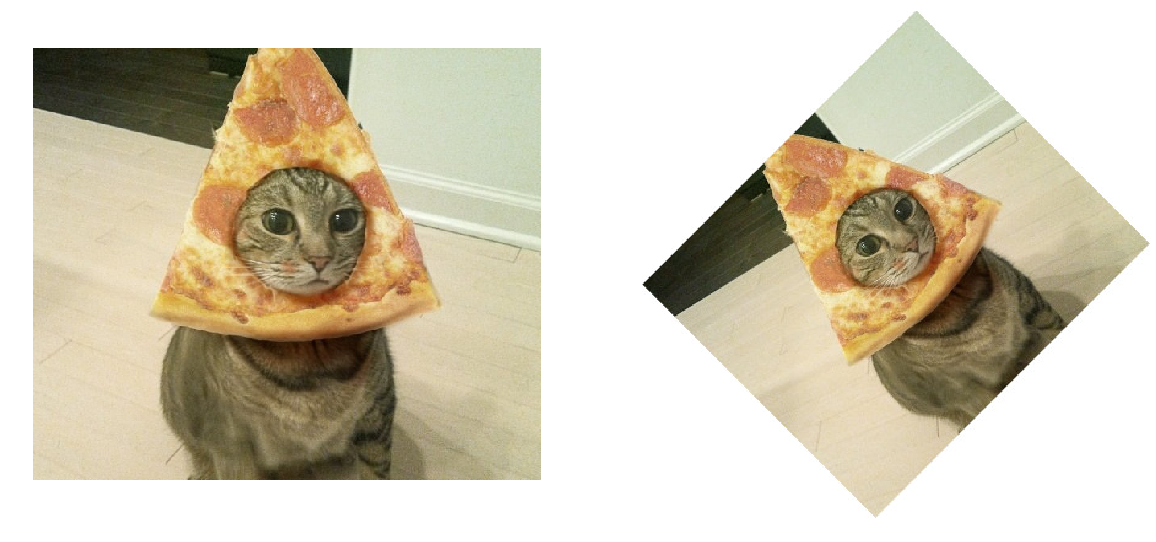

In [5]:
# Grab the first two images from the project.
img0 = my_project.Images[0]
img1 = my_project.Images[1]
    
DrawImagePairs(cv.cvtColor(img0.Original, cv.COLOR_BGR2RGB), cv.cvtColor(img1.Original, cv.COLOR_BGR2RGB))

calculating keypoints for C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
..found 32 for C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
calculating keypoints for C:\Users\mar10675\JupyterOnGitHub\Images\cat_train.jpg
..found 34 for C:\Users\mar10675\JupyterOnGitHub\Images\cat_train.jpg


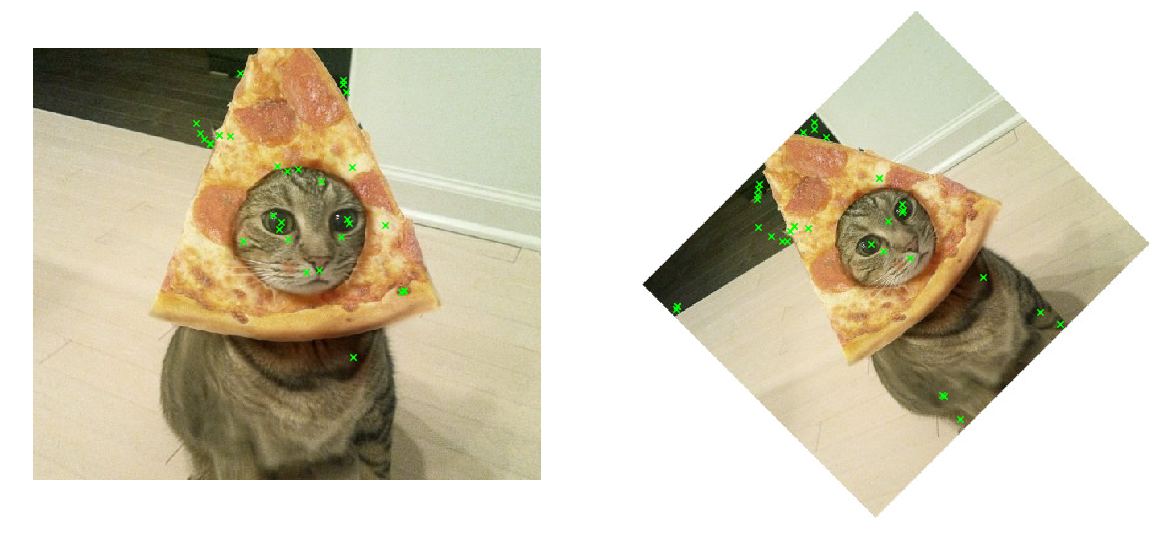

In [15]:
# Process keypoints.
my_project.DetectKeypoints(4000) # default 400.

# Grab the first two images from the project.
img0 = my_project.Images[0]
img1 = my_project.Images[1]
    
DrawKeypointPairs(cv.cvtColor(img0.Original, cv.COLOR_BGR2RGB), 
                  cv.cvtColor(img1.Original, cv.COLOR_BGR2RGB), 
                  img0.KeyPoints, 
                  img1.KeyPoints)

In [16]:
my_project.ComputeMatches()

matching C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg to C:\Users\mar10675\JupyterOnGitHub\Images\cat_train.jpg
...found 19
matching C:\Users\mar10675\JupyterOnGitHub\Images\cat_train.jpg to C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
...found 16


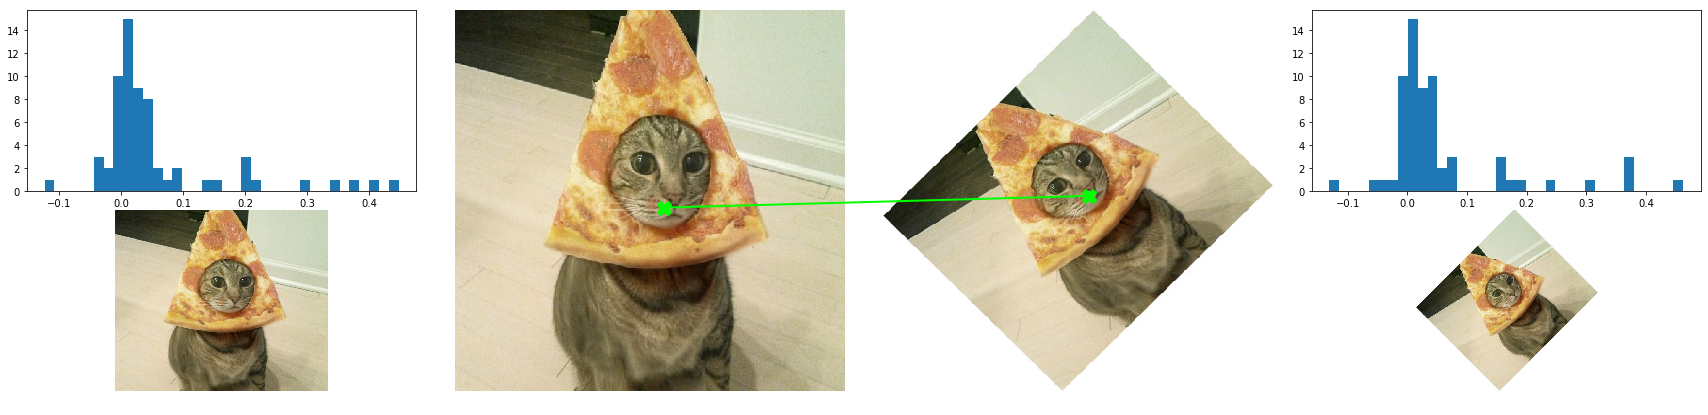

In [17]:
# The first match in the first matched image...
matches = img0.MatchedImages[0].Matches
matches_count = len(matches)

# Select a random match
i = randrange(0, matches_count)

match = matches[i]

kp1 = img0.KeyPoints[match.queryIdx]
ds1 = img0.Descriptors[match.queryIdx]
kp2 = img1.KeyPoints[match.trainIdx]
ds2 = img1.Descriptors[match.trainIdx]

DrawDescriptorPairs(cv.cvtColor(img0.Original, cv.COLOR_BGR2RGB), 
                    cv.cvtColor(img1.Original, cv.COLOR_BGR2RGB), 
                    kp1, 
                    kp2, 
                    ds1, 
                    ds2)


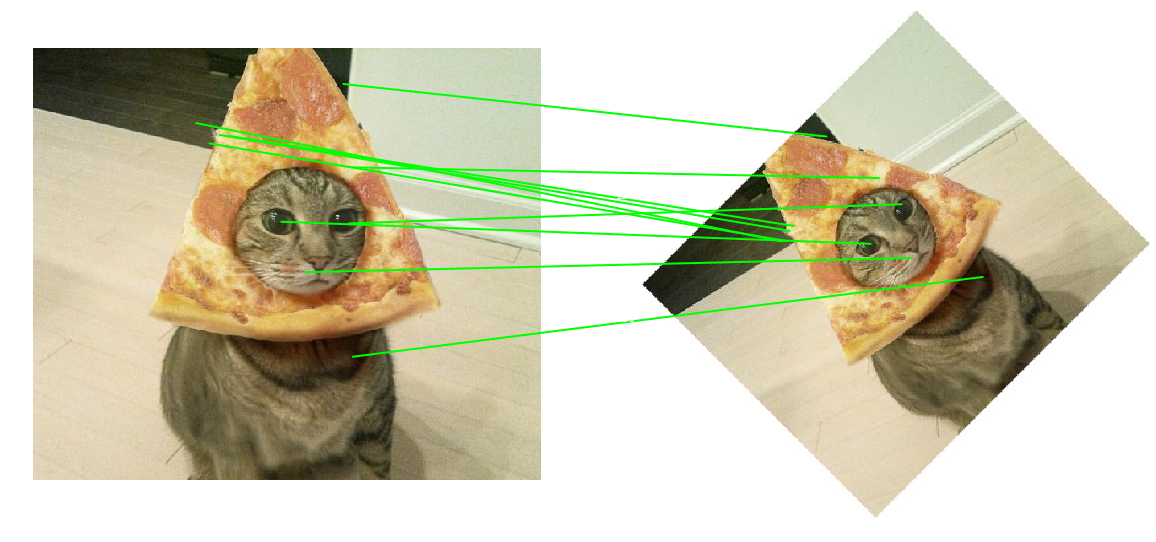

In [25]:
# Draw some matches

# The first match in the first matched image...
matches = img0.MatchedImages[0].Matches[:10]
total_matches = len(img0.MatchedImages[0].Matches)

DrawMatches(cv.cvtColor(img0.Original, cv.COLOR_BGR2RGB), 
            cv.cvtColor(img1.Original, cv.COLOR_BGR2RGB), 
            img0.KeyPoints, 
            img1.KeyPoints, 
            matches[:40])

plt.savefig('cat.png')